# Step and Turn Checks
Let's check whether the simulated positions have similar movement characteristics to the GPS data

In [36]:
import pandas as pd
import geopandas as gpd
import plotly as plt
import plotly.graph_objects as go
import plotly.express as px


In [2]:
csv = '../../output/agent_log.csv'

In [3]:
df = pd.read_csv(csv)

In [8]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.x, df.y), crs="EPSG:5070"
)

In [9]:
gdf 

,Timestamp,UUID,UID,Rank,Is Male,Is Fawn,Has HomeRange,x,y,centroid_x,centroid_y,Suitable Location,Behaviour State,Disease State,Data1,Data2,geometry
0,2000-01-01T01:00:00,f63f40e3-2c5e-4a40-9840-807876427d00,"(0, 0, 0)",0,False,False,False,1.615353e+06,1.956968e+06,1.615218e+06,1.956856e+06,False,Behaviour_State.DISPERSE,Infected,"DiscretePoint(50, 546, 0)",84.0,POINT (1615353.397 1956968.151)
1,2000-01-01T01:00:00,34f31ca2-a775-4e29-a835-828994b5000b,"(1, 0, 0)",0,True,False,False,1.615632e+06,1.971942e+06,1.615580e+06,1.972005e+06,False,Behaviour_State.DISPERSE,Infected,"DiscretePoint(59, 47, 0)",0.0,POINT (1615631.643 1971942.111)
2,2000-01-01T01:00:00,9e88c1eb-32db-4ac5-9818-bcd8e68bcc9c,"(2, 0, 0)",0,False,False,False,1.615237e+06,1.952527e+06,1.615265e+06,1.952556e+06,True,Behaviour_State.DISPERSE,Infected,"DiscretePoint(46, 694, 0)",76.0,POINT (1615237.341 1952527.242)
3,2000-01-01T01:00:00,c0f3313e-c86b-4389-905c-7204cff38aa1,"(3, 0, 0)",0,False,False,False,1.614327e+06,1.970288e+06,1.614352e+06,1.970350e+06,True,Behaviour_State.DISPERSE,Infected,"DiscretePoint(16, 102, 0)",82.0,POINT (1614326.597 1970287.968)
4,2000-01-01T01:00:00,80ec563a-e3b8-4bf8-a350-c400f2027ef8,"(4, 0, 0)",0,True,False,False,1.617735e+06,1.967970e+06,1.617739e+06,1.968018e+06,True,Behaviour_State.DISPERSE,Infected,"DiscretePoint(129, 179, 0)",88.0,POINT (1617734.969 1967969.665)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49974,2000-01-05T04:00:00,49609af6-0a95-45ba-901f-af35c472dc33,"(30, 0, 3)",3,False,False,False,1.632951e+06,1.960791e+06,1.631322e+06,1.960827e+06,False,Behaviour_State.DISPERSE,Recovered,"DiscretePoint(637, 418, 0)",55.0,POINT (1632950.596 1960790.735)
49975,2000-01-05T04:00:00,1a8e1e2c-725d-4c5e-ab9b-4c3ea01c3e11,"(1, 0, 3)",3,True,False,False,1.632786e+06,1.971546e+06,1.630804e+06,1.971691e+06,False,Behaviour_State.DISPERSE,Susceptible,"DiscretePoint(631, 60, 0)",30.0,POINT (1632786.108 1971545.964)
49976,2000-01-05T04:00:00,af8b0a09-d285-48cf-a4f3-9c9ceb7beda3,"(61, 0, 3)",3,True,False,True,1.632973e+06,1.970355e+06,1.632546e+06,1.970065e+06,False,Behaviour_State.EXPLORE,Susceptible,"DiscretePoint(637, 99, 0)",24.0,POINT (1632972.781 1970355.461)
49977,2000-01-05T04:00:00,602d5ea4-35f9-4f9c-b022-a674a08cca13,"(41, 0, 3)",3,False,False,False,1.632599e+06,1.964051e+06,1.630030e+06,1.962943e+06,False,Behaviour_State.DISPERSE,Infected,"DiscretePoint(625, 310, 0)",38.0,POINT (1632599.381 1964050.881)


## Group and shift
Let's group the positions by UUID and then shift by one position to calculate lead/lag points. It's here where you would normally sort the rows to ensure timestamps in order, but it comes that way out the sim so no worries

In [28]:
gdf['prev_geom'] = gdf.groupby('UUID')['geometry'].shift()
gdf['prev_prev_geom'] = gdf.groupby('UUID')['prev_geom'].shift() 
gdf['geom-to-prev_distance'] = gdf['geometry'].distance(gdf['prev_geom'])
gdf['prev_time'] = gdf.groupby('UUID')['Timestamp'].shift() 
# gdf['time_delta'] = gdf.groupby('UUID')['Timestamp'].shift() 
# gdf['meters_per_hour'] = gdf['lag_geom_delta_meters']/ (pd.to_timedelta(gdf['prev_time'])/datetime.timedelta(hours=1))

In [34]:
gdf[gdf['UUID'] == 'f63f40e3-2c5e-4a40-9840-807876427d00']

,Timestamp,UUID,UID,Rank,Is Male,Is Fawn,Has HomeRange,x,y,centroid_x,...,Data1,Data2,geometry,prev_geom,prev_prev_geom,geom-to-prev_distance,prev-to-prev2_distance,prev_time,time_delta,time-delta
0,2000-01-01T01:00:00,f63f40e3-2c5e-4a40-9840-807876427d00,"(0, 0, 0)",0,False,False,False,1.615353e+06,1.956968e+06,1.615218e+06,...,"DiscretePoint(50, 546, 0)",84.0,POINT (1615353.397 1956968.151),None,None,NaN,NaN,NaN,NaN,NaN
500,2000-01-01T02:00:00,f63f40e3-2c5e-4a40-9840-807876427d00,"(0, 0, 0)",0,False,False,False,1.615367e+06,1.956982e+06,1.615218e+06,...,"DiscretePoint(51, 545, 0)",0.0,POINT (1615366.76 1956981.631),POINT (1615353.397 1956968.151),None,18.980961,NaN,2000-01-01T01:00:00,2000-01-01T01:00:00,NaN
1000,2000-01-01T03:00:00,f63f40e3-2c5e-4a40-9840-807876427d00,"(0, 0, 0)",0,False,False,False,1.615376e+06,1.956982e+06,1.615218e+06,...,"DiscretePoint(51, 545, 0)",0.0,POINT (1615376.183 1956982.316),POINT (1615366.76 1956981.631),POINT (1615353.397 1956968.151),9.448164,18.980961,2000-01-01T02:00:00,2000-01-01T02:00:00,NaN
1500,2000-01-01T04:00:00,f63f40e3-2c5e-4a40-9840-807876427d00,"(0, 0, 0)",0,False,False,False,1.616096e+06,1.956677e+06,1.615218e+06,...,"DiscretePoint(75, 555, 0)",28.0,POINT (1616096.225 1956676.899),POINT (1615376.183 1956982.316),POINT (1615366.76 1956981.631),782.137651,9.448164,2000-01-01T03:00:00,2000-01-01T03:00:00,NaN
2000,2000-01-01T05:00:00,f63f40e3-2c5e-4a40-9840-807876427d00,"(0, 0, 0)",0,False,False,False,1.616094e+06,1.956681e+06,1.615218e+06,...,"DiscretePoint(75, 555, 0)",28.0,POINT (1616094.229 1956680.904),POINT (1616096.225 1956676.899),POINT (1615376.183 1956982.316),4.475065,782.137651,2000-01-01T04:00:00,2000-01-01T04:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47484,2000-01-05T00:00:00,f63f40e3-2c5e-4a40-9840-807876427d00,"(0, 0, 0)",0,False,False,True,1.614896e+06,1.958146e+06,1.615801e+06,...,"DiscretePoint(35, 506, 0)",86.0,POINT (1614896.326 1958145.721),POINT (1614892.527 1958161.668),POINT (1614906.837 1958219.302),16.393452,59.383337,2000-01-04T23:00:00,2000-01-04T23:00:00,NaN
47983,2000-01-05T01:00:00,f63f40e3-2c5e-4a40-9840-807876427d00,"(0, 0, 0)",0,False,False,True,1.614925e+06,1.958123e+06,1.615801e+06,...,"DiscretePoint(36, 507, 0)",92.0,POINT (1614924.607 1958122.577),POINT (1614896.326 1958145.721),POINT (1614892.527 1958161.668),36.544197,16.393452,2000-01-05T00:00:00,2000-01-05T00:00:00,NaN
48482,2000-01-05T02:00:00,f63f40e3-2c5e-4a40-9840-807876427d00,"(0, 0, 0)",0,False,False,True,1.615235e+06,1.957821e+06,1.615801e+06,...,"DiscretePoint(46, 517, 0)",94.0,POINT (1615234.775 1957820.849),POINT (1614924.607 1958122.577),POINT (1614896.326 1958145.721),432.716498,36.544197,2000-01-05T01:00:00,2000-01-05T01:00:00,NaN
48981,2000-01-05T03:00:00,f63f40e3-2c5e-4a40-9840-807876427d00,"(0, 0, 0)",0,False,False,True,1.615243e+06,1.957776e+06,1.615801e+06,...,"DiscretePoint(46, 519, 0)",93.0,POINT (1615243.379 1957775.873),POINT (1615234.775 1957820.849),POINT (1614924.607 1958122.577),45.792078,432.716498,2000-01-05T02:00:00,2000-01-05T02:00:00,NaN


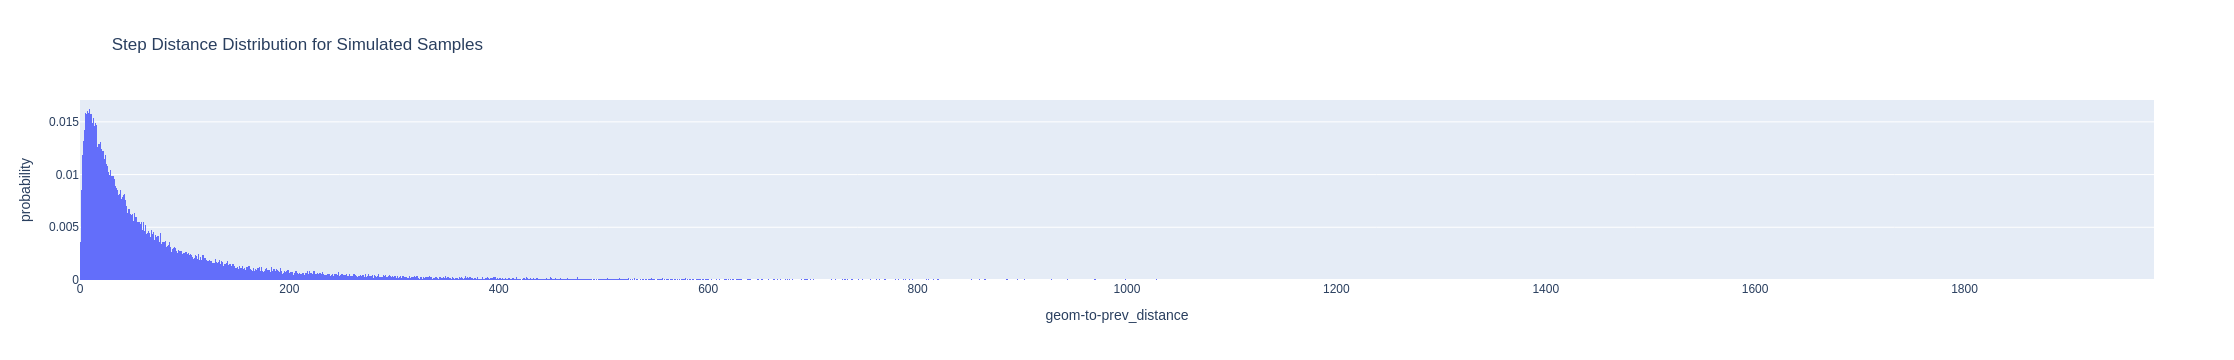

In [39]:
filtered_data = gdf[gdf['geom-to-prev_distance'] < 2000]

fig = px.histogram(filtered_data, 
                   x="geom-to-prev_distance", 
                   nbins = 2000,
                   histnorm='probability',
                   title = 'Step Distance Distribution for Simulated Samples')

fig.show()